In [1]:
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Regresión Logística

## Titanic
Voy a crear un modelo que prediga la probabilidad de supervivencia de los pasajeros

https://www.kaggle.com/c/titanic/data?select=train.csv

0. Importar data de training y testing. Agregarle a la tabla de testing la columna survived proveniente de la tabla gender_submission

In [29]:
train_data = pd.read_csv("Titanic/train.csv")
test_data = pd.read_csv("Titanic/test.csv")

In [31]:
resultados = pd.read_csv("Titanic/gender_submission.csv")

In [33]:
train_data.shape

(891, 12)

In [35]:
test_data = test_data.merge(resultados, how = "left")
test_data.shape

(418, 12)

1. Buscar columnas con valores nulos y cantidad de nulos en cada una. Fijarse el porcentaje de los datos nulos que representan sobre el total.

In [23]:
train_data.isnull().sum() / len(train_data) * 100

PassengerId     0.000000
Survived        0.000000
Pclass          0.000000
Name            0.000000
Sex             0.000000
Age            19.865320
SibSp           0.000000
Parch           0.000000
Ticket          0.000000
Fare            0.000000
Cabin          77.104377
Embarked        0.224467
dtype: float64

In [25]:
test_data.isnull().sum() / len(test_data) * 100

PassengerId     0.000000
Pclass          0.000000
Name            0.000000
Sex             0.000000
Age            20.574163
SibSp           0.000000
Parch           0.000000
Ticket          0.000000
Fare            0.239234
Cabin          78.229665
Embarked        0.000000
Survived        0.000000
dtype: float64

2. En base al resultado anterior. Busco columnas que considero que tienen sentido completar y las que debería eliminar, Entonces elimino la que corresponda de la tabla de test y de train.

In [39]:
train_data.drop(columns = "Cabin", inplace = True)
test_data.drop(columns = "Cabin", inplace = True)

3. Completo valores nulos con el criterio que considro correcto en cada una de las columnas (que tengan sentido completar). Esto debe hacerse tanto en la tabla de training como la de testing (con el mismo criterio en ambas).

   Verifico como se distribuyen los valores de cada columna con un gráfico previamente para tener más herramientas en la decisión

<Axes: xlabel='Age', ylabel='Count'>

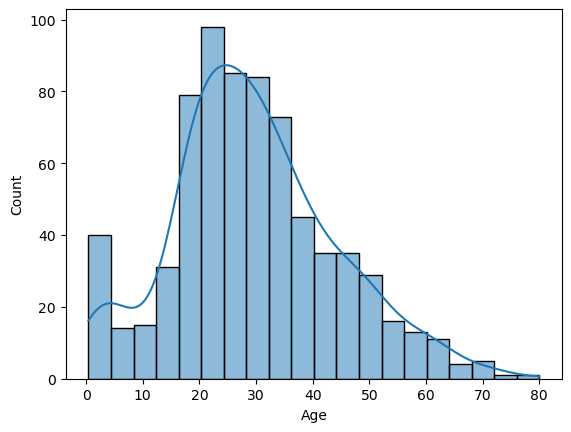

In [41]:
# Verifico como se distribuyen las edades
sns.histplot(train_data["Age"], kde = True)

In [45]:
train_data.Age.median()

28.0

In [47]:
mediana = train_data.Age.median()
train_data["Age"] = train_data["Age"].fillna(mediana)

In [49]:
mediana = test_data.Age.median()
test_data["Age"] = test_data["Age"].fillna(mediana)

<Axes: xlabel='Embarked', ylabel='count'>

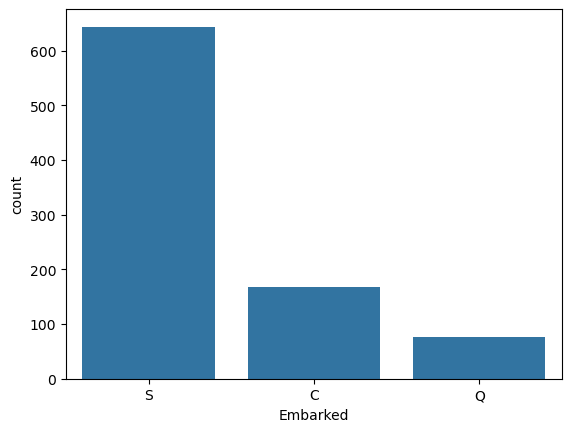

In [51]:
sns.countplot(x = train_data["Embarked"])

In [55]:
train_data.Embarked.mode()[0]

'S'

In [57]:
moda = train_data.Embarked.mode()[0]
train_data["Embarked"] = train_data["Embarked"].fillna(moda)

In [59]:
moda = test_data.Embarked.mode()[0]
test_data["Embarked"] = test_data["Embarked"].fillna(moda)

In [63]:
test_data.isnull().sum()

PassengerId    0
Pclass         0
Name           0
Sex            0
Age            0
SibSp          0
Parch          0
Ticket         0
Fare           1
Embarked       0
Survived       0
dtype: int64

In [71]:
test_data.loc[test_data.Fare.isnull(),:]

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,Survived
152,1044,3,"Storey, Mr. Thomas",male,60.5,0,0,3701,NaN,S,0


In [81]:
promedio = test_data.loc[test_data.Pclass == 3, "Fare"].mean()
test_data["Fare"] = test_data["Fare"].fillna(promedio)

4. Realizo análisis exploratorio. Grafico las personas que sobrevivieron por:
    - Clase (Pclass)
    - Sexo (Sex)
    - Costo de boleto (Fare)

<Axes: xlabel='Pclass', ylabel='count'>

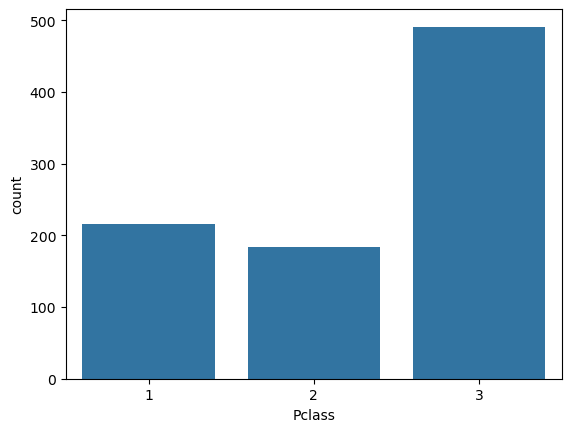

In [89]:
sns.countplot(x = train_data.Pclass)

In [93]:
data_agrupada = train_data.groupby(["Pclass", "Survived"]).agg(Cantidad = ("Survived", "count")).reset_index()
data_agrupada

,Pclass,Survived,Cantidad
0,1,0,80
1,1,1,136
2,2,0,97
3,2,1,87
4,3,0,372
5,3,1,119


<Axes: xlabel='Pclass', ylabel='Cantidad'>

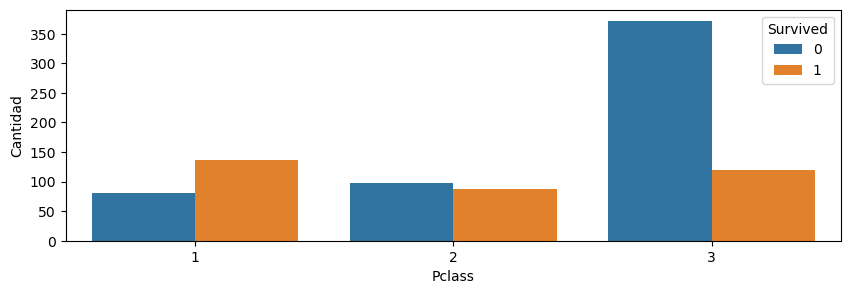

In [109]:
plt.figure(figsize = (10,3))
sns.barplot(
    data = data_agrupada, 
    x = "Pclass", 
    y = "Cantidad", 
    hue = "Survived"
)

In [113]:
data_agrupada = train_data.groupby(["Sex", "Survived"]).agg(Cantidad = ("Survived", "count")).reset_index()
data_agrupada

,Sex,Survived,Cantidad
0,female,0,81
1,female,1,233
2,male,0,468
3,male,1,109


<Axes: xlabel='Sex', ylabel='Cantidad'>

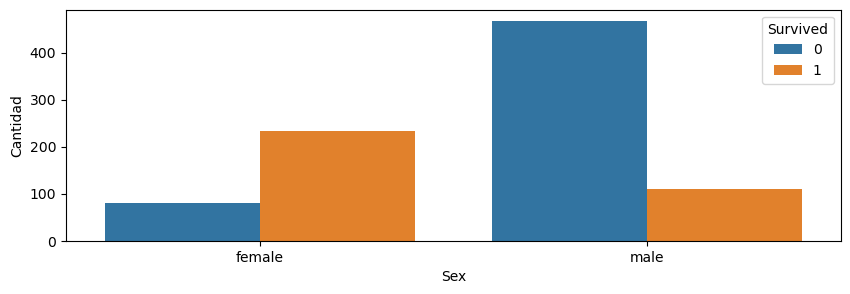

In [117]:
plt.figure(figsize = (10,3))
sns.barplot(
    data = data_agrupada, 
    x = "Sex", 
    y = "Cantidad", 
    hue = "Survived"
)

<Axes: xlabel='Age', ylabel='Count'>

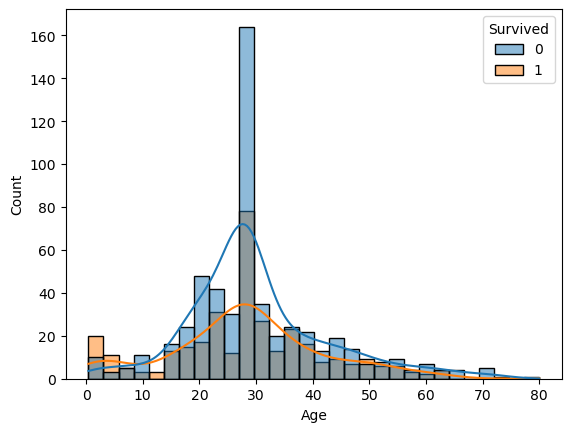

In [124]:
sns.histplot(x=train_data.Age, hue = train_data.Survived, kde = True)

<Axes: xlabel='Age', ylabel='Count'>

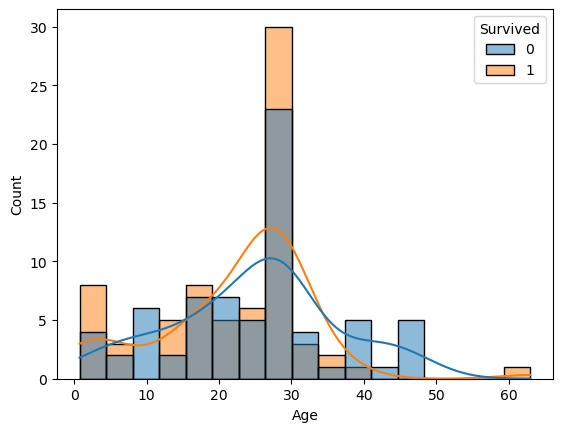

In [132]:
data_filtro = train_data.loc[(train_data.Pclass == 3) & (train_data.Sex == "female"), :]
sns.histplot(x=data_filtro.Age, hue = data_filtro.Survived, kde = True)

<Axes: >

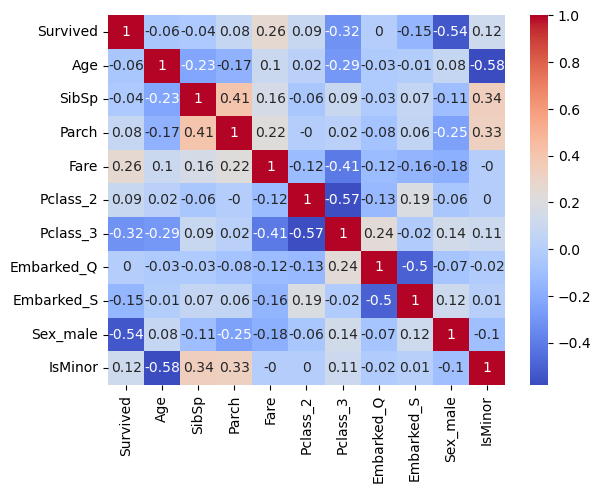

In [182]:
sns.heatmap(train_data.corr().round(2), cmap = "coolwarm", annot = True)

5. Verifico columnas del DataFrame e identifico sobre cuales se deberían generar variables dummies.
   Genero columnas de dummies sobre "Pclass","Embarked" y "Sex". Aplico cambios en training y testing

In [134]:
train_data.dtypes

PassengerId      int64
Survived         int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Embarked        object
dtype: object

In [136]:
test_data = pd.get_dummies(
    test_data, 
    columns=["Pclass","Embarked","Sex"],
    drop_first = True
)

train_data = pd.get_dummies(
    train_data, 
    columns=["Pclass","Embarked","Sex"],
    drop_first = True
)

6. Elimino columnas del dataset que considere que no suman al modelo. Lo hago en testing y training

In [138]:
train_data.drop(columns=["PassengerId", "Name", "Ticket"], inplace = True)
test_data.drop(columns=["PassengerId", "Name", "Ticket"], inplace = True)

7. Agrego una columna llamada "IsMinor" que sea 1 en caso de tener 16 años o menos y 0 en caso contrario. Lo hago para testing y training

In [140]:
train_data["IsMinor"] = np.where(train_data["Age"]<= 16, 1, 0)
test_data["IsMinor"] = np.where(test_data["Age"]<= 16, 1, 0)

In [142]:
train_data.head()

,Survived,Age,SibSp,Parch,Fare,Pclass_2,Pclass_3,Embarked_Q,Embarked_S,Sex_male,IsMinor
0,0,22.0,1,0,7.2500,False,True,False,True,True,0
1,1,38.0,1,0,71.2833,False,False,False,False,False,0
2,1,26.0,0,0,7.9250,False,True,False,True,False,0
3,1,35.0,1,0,53.1000,False,False,False,True,False,0
4,0,35.0,0,0,8.0500,False,True,False,True,True,0


8. Ajusto modelo considerando todas las variables del dataset de training.

In [144]:
X_train = train_data.drop(columns = "Survived")
y_train = train_data["Survived"]

In [148]:
X_test = test_data.drop(columns = "Survived")
y_test = test_data["Survived"]

In [150]:
from sklearn.linear_model import LogisticRegression

modelo = LogisticRegression(max_iter = 10000)
modelo.fit(X_train, y_train)

LogisticRegression(max_iter=10000)

9. Valido el modelo con datos de testing, agrego dos columnas a test_data:
    * predicción: valor 0 o 1
    * probabilidad_prediccion: valor de la probabilidad devuelta por el modelo

In [156]:
y_pred = modelo.predict(X_test)
y_pred_proba = modelo.predict_proba(X_test)[:,1]
y_pred_proba

array([0.11667439, 0.38381536, 0.18475581, 0.09604201, 0.49081626,
       0.27627215, 0.66752484, 0.17977245, 0.7275346 , 0.05662403,
       0.0957777 , 0.31713548, 0.90185084, 0.09791513, 0.82973867,
       0.84605563, 0.29843855, 0.15373731, 0.49722556, 0.58976889,
       0.30552899, 0.26306797, 0.90972097, 0.54831301, 0.90824361,
       0.04183505, 0.94225493, 0.14931545, 0.34650794, 0.07203162,
       0.1275818 , 0.15583537, 0.39803394, 0.43422076, 0.43673998,
       0.16134675, 0.59254442, 0.62586358, 0.10039832, 0.11386764,
       0.09523268, 0.41845924, 0.07134207, 0.81584347, 0.83136946,
       0.09983419, 0.41951071, 0.13556287, 0.89429826, 0.47104582,
       0.37462637, 0.34319917, 0.69628527, 0.85022577, 0.34368855,
       0.10936665, 0.08102589, 0.09973598, 0.06929799, 0.96849351,
       0.11756016, 0.23606727, 0.11514307, 0.70699547, 0.77332716,
       0.83048   , 0.72575113, 0.32635939, 0.49790573, 0.81115189,
       0.69742686, 0.10837363, 0.58130577, 0.51142356, 0.96253

In [166]:
y_pred = (y_pred_proba > ) * 1

array([0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0,
       1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1,
       1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1,
       1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1,
       1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1,
       1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1,
       0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0,
       1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,
       0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1,
       0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0,

10. Calculo matriz de confusión

In [168]:
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score

In [172]:
matriz_confusion = confusion_matrix(y_test, y_pred)
matriz_confusion

array([[253,  13],
       [ 16, 136]], dtype=int64)

In [174]:
TN = matriz_confusion[0][0] # predije que no sobrevivían y no lo hicieron = 253
TP = matriz_confusion[1][1] # predije que sobrevivían y lo hicieron = 136
FN = matriz_confusion[1][0] # predije que no sobrevivían pero si sobrevivieron = 16
FP = matriz_confusion[0][1] # predije que sobrevivían pero no lo hicieron = 13

In [176]:
FN

16

11. Calculo Accuracy

In [178]:
(TN + TP) / (TN + TP + FN + FP) # porcentaje de aciertos sobre el total de predicciones

0.930622009569378

12. Calculo sensibilidad

In [184]:
TP / (TP + FN) # del total que personas que sobrevivieron, cuantas predije bien

0.8947368421052632

13. Calculo especificidad

In [186]:
TN / (TN + FP)  # del total que personas que no sobrevivieron, cuantas predije bien

0.9511278195488722

14. Grafico curva de ROC

In [212]:
threshold

array([1.97718295, 0.97718295, 0.83974052, 0.83882531, 0.81925359,
       0.81717308, 0.77484056, 0.77332716, 0.77221663, 0.76457996,
       0.70158024, 0.69742686, 0.68935258, 0.68282757, 0.68274147,
       0.68271632, 0.66692529, 0.66476873, 0.61071764, 0.60390586,
       0.59260441, 0.59254442, 0.55103337, 0.53210055, 0.53178432,
       0.52868511, 0.52620352, 0.51565716, 0.51442493, 0.49790573,
       0.49722556, 0.49547576, 0.46736579, 0.45843222, 0.45343207,
       0.4355119 , 0.43422076, 0.43113557, 0.43079501, 0.41951071,
       0.41845924, 0.41792723, 0.40148916, 0.39963784, 0.39803394,
       0.38425179, 0.38381536, 0.33807495, 0.33781225, 0.26700878,
       0.26390375, 0.26251344, 0.26138781, 0.25075909, 0.24407073,
       0.23436189, 0.23418382, 0.15077764, 0.15001431, 0.13699211,
       0.1366791 , 0.13667713, 0.13562308, 0.13556287, 0.09778207,
       0.09773971, 0.09605927, 0.09604201, 0.09583081, 0.0957777 ,
       0.09566731, 0.09565871, 0.07405782, 0.07203162, 0.05943

In [190]:
# 1-especificidad, sensibilidad, umbral
especificidad_inv, sensibilidad, threshold = roc_curve(y_test, y_pred_proba)

In [194]:
recta_x = [i * 0.01 for i in range(101)]
recta_y = recta_x

In [198]:
recta_y

[0.0,
 0.01,
 0.02,
 0.03,
 0.04,
 0.05,
 0.06,
 0.07,
 0.08,
 0.09,
 0.1,
 0.11,
 0.12,
 0.13,
 0.14,
 0.15,
 0.16,
 0.17,
 0.18,
 0.19,
 0.2,
 0.21,
 0.22,
 0.23,
 0.24,
 0.25,
 0.26,
 0.27,
 0.28,
 0.29,
 0.3,
 0.31,
 0.32,
 0.33,
 0.34,
 0.35000000000000003,
 0.36,
 0.37,
 0.38,
 0.39,
 0.4,
 0.41000000000000003,
 0.42,
 0.43,
 0.44,
 0.45,
 0.46,
 0.47000000000000003,
 0.48,
 0.49,
 0.5,
 0.51,
 0.52,
 0.53,
 0.54,
 0.55,
 0.56,
 0.5700000000000001,
 0.58,
 0.59,
 0.6,
 0.61,
 0.62,
 0.63,
 0.64,
 0.65,
 0.66,
 0.67,
 0.68,
 0.6900000000000001,
 0.7000000000000001,
 0.71,
 0.72,
 0.73,
 0.74,
 0.75,
 0.76,
 0.77,
 0.78,
 0.79,
 0.8,
 0.81,
 0.8200000000000001,
 0.8300000000000001,
 0.84,
 0.85,
 0.86,
 0.87,
 0.88,
 0.89,
 0.9,
 0.91,
 0.92,
 0.93,
 0.9400000000000001,
 0.9500000000000001,
 0.96,
 0.97,
 0.98,
 0.99,
 1.0]

<Axes: >

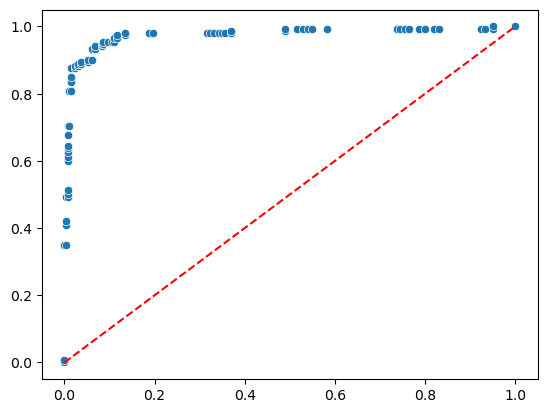

In [214]:
sns.lineplot(x = recta_x, y = recta_y, ls = "--",  color = "red")
sns.scatterplot(x = especificidad_inv, y = sensibilidad)

15. Calculo valor de área bajo la curva de ROC

In [202]:
roc_auc_score(y_test, y_pred_proba)

0.9762316976652157